## Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import json

import tensorflow as tf
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

# custom helper functions
from utils import *

from xgboost import XGBClassifier

RANDOM_SEED = 0

2022-05-02 21:20:52.088327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 21:20:52.088374: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load Data & Develop Test/Train Splits

In [2]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_data.json"
GTZAN_JSON_PATH = "/storage/graham/music/gtzan_data.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [3]:
%%time
genres, X, y = load_mfcc_data(FMA_JSON_PATH)

CPU times: user 2min 32s, sys: 14.6 s, total: 2min 47s
Wall time: 2min 51s


In [4]:
SPLIT = 0.3

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT)

# reshape MFCC to be a vector
X_train_vec = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_vec = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

X_vec = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

## Transfer Learning to GTZAN

### Load in GTZAN Dataset

In [5]:
%%time
genres_gtzan, X_gtzan, y_gtzan = load_mfcc_data(GTZAN_JSON_PATH)

CPU times: user 8.89 s, sys: 1.17 s, total: 10.1 s
Wall time: 10.3 s


In [6]:
# create train/test split
X_gtzan_train, X_gtzan_val, X_gtzan_test, y_gtzan_train, y_gtzan_val, y_gtzan_test = test_train_val_split(X_gtzan, y_gtzan, test_size=0.3, val_size=0.3, rseed=RANDOM_SEED)

X_gtzan_vec = X_gtzan.reshape(X_gtzan.shape[0], X_gtzan.shape[1]*X_gtzan.shape[2])

### Load Previous CNN Model

In [7]:
base_model = keras.models.load_model(MODEL_PATH + "/fma_cnn/")
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

2022-05-02 21:23:56.968277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 21:23:56.968313: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 21:23:56.968340: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (earhart): /proc/driver/nvidia/version does not exist
2022-05-02 21:23:56.968535: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 129, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 2, 32)        0         
 2D)                                                             
                                                      

### Replace Last Layer to Match GTZAN Dimensionality

In [8]:
gtzan_predict = keras.layers.Dense(len(genres_gtzan), activation='softmax', name='gtzan')
gtzan_transfer = replace_intermediate_layer_in_keras(base_model, 12, gtzan_predict)
gtzan_transfer._name = "FMA_Transfer_to_GTZAN"
gtzan_transfer.summary()

Model: "FMA_Transfer_to_GTZAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 259, 13, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 129, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 2, 3

### Fine Tune on GTZAN Data

In [9]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
gtzan_transfer.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# prep data for CNN / reshape
size = (X_train.shape[1], X_train.shape[2])

X_gtzan_train_cnn = X_gtzan_train[..., np.newaxis]
X_gtzan_val_cnn = X_gtzan_val[..., np.newaxis]
X_gtzan_test_cnn = X_gtzan_test[..., np.newaxis]

X_gtzan_train_cnn = tf.image.resize(X_gtzan_train_cnn, size).numpy()
X_gtzan_val_cnn = tf.image.resize(X_gtzan_val_cnn, size).numpy()
X_gtzan_test_cnn = tf.image.resize(X_gtzan_test_cnn, size).numpy()

Epoch 1/30
139/153 [==========================>...] - ETA: 0s - loss: 2.8781 - accuracy: 0.1344
Epoch 1: val_loss improved from inf to 2.24070, saving model to /storage/graham/music/models//gtzan_transfer/


2022-05-02 21:23:59.706178: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 2.8471 - accuracy: 0.1363 - val_loss: 2.2407 - val_accuracy: 0.1621 - lr: 0.0010
Epoch 2/30
152/153 [============================>.] - ETA: 0s - loss: 2.3364 - accuracy: 0.1922
Epoch 2: val_loss improved from 2.24070 to 1.99770, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 2.3355 - accuracy: 0.1925 - val_loss: 1.9977 - val_accuracy: 0.2456 - lr: 0.0010
Epoch 3/30
146/153 [===========================>..] - ETA: 0s - loss: 2.1080 - accuracy: 0.2402
Epoch 3: val_loss improved from 1.99770 to 1.86604, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 2.1070 - accuracy: 0.2405 - val_loss: 1.8660 - val_accuracy: 0.3038 - lr: 0.0010
Epoch 4/30
144/153 [===========================>..] - ETA: 0s - loss: 1.9682 - accuracy: 0.2704
Epoch 4: val_loss improved from 1.86604 to 1.79658, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.9679 - accuracy: 0.2702 - val_loss: 1.7966 - val_accuracy: 0.3305 - lr: 0.0010
Epoch 5/30
143/153 [===========================>..] - ETA: 0s - loss: 1.8898 - accuracy: 0.2874
Epoch 5: val_loss improved from 1.79658 to 1.74685, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 14ms/step - loss: 1.8884 - accuracy: 0.2878 - val_loss: 1.7468 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 6/30
150/153 [============================>.] - ETA: 0s - loss: 1.8239 - accuracy: 0.3215
Epoch 6: val_loss improved from 1.74685 to 1.71492, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.8241 - accuracy: 0.3203 - val_loss: 1.7149 - val_accuracy: 0.3624 - lr: 0.0010
Epoch 7/30
143/153 [===========================>..] - ETA: 0s - loss: 1.8044 - accuracy: 0.3280
Epoch 7: val_loss improved from 1.71492 to 1.69204, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.7959 - accuracy: 0.3290 - val_loss: 1.6920 - val_accuracy: 0.3720 - lr: 0.0010
Epoch 8/30
152/153 [============================>.] - ETA: 0s - loss: 1.7753 - accuracy: 0.3427
Epoch 8: val_loss improved from 1.69204 to 1.67395, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 14ms/step - loss: 1.7752 - accuracy: 0.3423 - val_loss: 1.6740 - val_accuracy: 0.3810 - lr: 0.0010
Epoch 9/30
151/153 [============================>.] - ETA: 0s - loss: 1.7453 - accuracy: 0.3512
Epoch 9: val_loss improved from 1.67395 to 1.66556, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.7462 - accuracy: 0.3517 - val_loss: 1.6656 - val_accuracy: 0.3877 - lr: 0.0010
Epoch 10/30
152/153 [============================>.] - ETA: 0s - loss: 1.7457 - accuracy: 0.3559
Epoch 10: val_loss improved from 1.66556 to 1.65356, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.7464 - accuracy: 0.3558 - val_loss: 1.6536 - val_accuracy: 0.3901 - lr: 0.0010
Epoch 11/30
144/153 [===========================>..] - ETA: 0s - loss: 1.7305 - accuracy: 0.3557
Epoch 11: val_loss improved from 1.65356 to 1.65045, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.7307 - accuracy: 0.3562 - val_loss: 1.6505 - val_accuracy: 0.3882 - lr: 0.0010
Epoch 12/30
152/153 [============================>.] - ETA: 0s - loss: 1.7316 - accuracy: 0.3491
Epoch 12: val_loss improved from 1.65045 to 1.64317, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.7322 - accuracy: 0.3480 - val_loss: 1.6432 - val_accuracy: 0.3896 - lr: 0.0010
Epoch 13/30
146/153 [===========================>..] - ETA: 0s - loss: 1.7287 - accuracy: 0.3607
Epoch 13: val_loss improved from 1.64317 to 1.64194, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.7310 - accuracy: 0.3609 - val_loss: 1.6419 - val_accuracy: 0.3872 - lr: 0.0010
Epoch 14/30
145/153 [===========================>..] - ETA: 0s - loss: 1.7259 - accuracy: 0.3547
Epoch 14: val_loss improved from 1.64194 to 1.63371, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.7247 - accuracy: 0.3564 - val_loss: 1.6337 - val_accuracy: 0.3920 - lr: 0.0010
Epoch 15/30
152/153 [============================>.] - ETA: 0s - loss: 1.7170 - accuracy: 0.3633
Epoch 15: val_loss improved from 1.63371 to 1.62891, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 15ms/step - loss: 1.7163 - accuracy: 0.3628 - val_loss: 1.6289 - val_accuracy: 0.3929 - lr: 0.0010
Epoch 16/30
151/153 [============================>.] - ETA: 0s - loss: 1.7216 - accuracy: 0.3647
Epoch 16: val_loss did not improve from 1.62891
153/153 [==============================] - 1s 7ms/step - loss: 1.7221 - accuracy: 0.3648 - val_loss: 1.6307 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 17/30
142/153 [==========================>...] - ETA: 0s - loss: 1.7184 - accuracy: 0.3563
Epoch 17: val_loss improved from 1.62891 to 1.62604, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.7162 - accuracy: 0.3566 - val_loss: 1.6260 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 18/30
146/153 [===========================>..] - ETA: 0s - loss: 1.7125 - accuracy: 0.3624
Epoch 18: val_loss improved from 1.62604 to 1.62295, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.7152 - accuracy: 0.3619 - val_loss: 1.6229 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 19/30
152/153 [============================>.] - ETA: 0s - loss: 1.7105 - accuracy: 0.3670
Epoch 19: val_loss did not improve from 1.62295
153/153 [==============================] - 1s 6ms/step - loss: 1.7097 - accuracy: 0.3669 - val_loss: 1.6252 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 20/30
153/153 [==============================] - ETA: 0s - loss: 1.6967 - accuracy: 0.3601
Epoch 20: val_loss improved from 1.62295 to 1.61997, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.6967 - accuracy: 0.3601 - val_loss: 1.6200 - val_accuracy: 0.3929 - lr: 0.0010
Epoch 21/30
143/153 [===========================>..] - ETA: 0s - loss: 1.7171 - accuracy: 0.3593
Epoch 21: val_loss improved from 1.61997 to 1.61835, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.7182 - accuracy: 0.3587 - val_loss: 1.6183 - val_accuracy: 0.3929 - lr: 0.0010
Epoch 22/30
147/153 [===========================>..] - ETA: 0s - loss: 1.7061 - accuracy: 0.3669
Epoch 22: val_loss did not improve from 1.61835
153/153 [==============================] - 1s 7ms/step - loss: 1.7077 - accuracy: 0.3644 - val_loss: 1.6221 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 23/30
145/153 [===========================>..] - ETA: 0s - loss: 1.7070 - accuracy: 0.3703
Epoch 23: val_loss improved from 1.61835 to 1.61820, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.7061 - accuracy: 0.3711 - val_loss: 1.6182 - val_accuracy: 0.3934 - lr: 0.0010
Epoch 24/30
145/153 [===========================>..] - ETA: 0s - loss: 1.7040 - accuracy: 0.3558
Epoch 24: val_loss improved from 1.61820 to 1.61817, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.7099 - accuracy: 0.3562 - val_loss: 1.6182 - val_accuracy: 0.3906 - lr: 0.0010
Epoch 25/30
146/153 [===========================>..] - ETA: 0s - loss: 1.7096 - accuracy: 0.3534
Epoch 25: val_loss did not improve from 1.61817
153/153 [==============================] - 1s 6ms/step - loss: 1.7060 - accuracy: 0.3560 - val_loss: 1.6190 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 26/30
153/153 [==============================] - ETA: 0s - loss: 1.7090 - accuracy: 0.3673
Epoch 26: val_loss improved from 1.61817 to 1.61495, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.7090 - accuracy: 0.3673 - val_loss: 1.6149 - val_accuracy: 0.3948 - lr: 0.0010
Epoch 27/30
148/153 [============================>.] - ETA: 0s - loss: 1.7025 - accuracy: 0.3699
Epoch 27: val_loss improved from 1.61495 to 1.61407, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.7037 - accuracy: 0.3691 - val_loss: 1.6141 - val_accuracy: 0.3977 - lr: 0.0010
Epoch 28/30
143/153 [===========================>..] - ETA: 0s - loss: 1.6933 - accuracy: 0.3700
Epoch 28: val_loss improved from 1.61407 to 1.61393, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.6904 - accuracy: 0.3703 - val_loss: 1.6139 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 29/30
145/153 [===========================>..] - ETA: 0s - loss: 1.7106 - accuracy: 0.3636
Epoch 29: val_loss improved from 1.61393 to 1.61316, saving model to /storage/graham/music/models//gtzan_transfer/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_transfer/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.7118 - accuracy: 0.3646 - val_loss: 1.6132 - val_accuracy: 0.3953 - lr: 0.0010
Epoch 30/30
148/153 [============================>.] - ETA: 0s - loss: 1.6990 - accuracy: 0.3699
Epoch 30: val_loss did not improve from 1.61316
153/153 [==============================] - 1s 6ms/step - loss: 1.6971 - accuracy: 0.3699 - val_loss: 1.6181 - val_accuracy: 0.3953 - lr: 0.0010


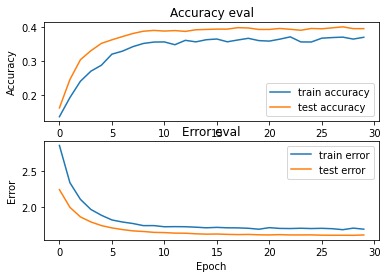

94/94 - 0s - loss: 1.6359 - accuracy: 0.3882 - 371ms/epoch - 4ms/step

Test accuracy: 0.38818424940109253
CPU times: user 19min 36s, sys: 3min 15s, total: 22min 52s
Wall time: 54.4 s


In [10]:
%%time

MODEL_SAVE_PATH = MODEL_PATH + "/gtzan_transfer/"
saveBest, es, lr = setup_callbacks(gtzan_transfer, MODEL_SAVE_PATH)

# train model
history = gtzan_transfer.fit(X_gtzan_train_cnn, y_gtzan_train, 
                             validation_data=(X_gtzan_val_cnn, y_gtzan_val), 
                             batch_size=32, 
                             epochs=30,
                             callbacks=[saveBest, es, lr])

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = gtzan_transfer.evaluate(X_gtzan_test_cnn, y_gtzan_test, verbose=2)
print('\nTest accuracy:', test_acc)